# AI Hub Raw Data - Metadata Analysis & EDA

This notebook performs exploratory data analysis on the AI Hub raw data collection.
It traverses all datasets in the `ai_hub_raw_data` folder and extracts metadata for analysis.

## Dataset Structure
- **Training & Validation** splits
- **Data Types**: 라벨링데이터 (labeled), 원천데이터 (source)
- **Domains**: 금융보험, 다산콜센터, 질병관리본부, 쇼핑

---

## 1. Setup & Imports

In [2]:
import os
import json
import zipfile
from pathlib import Path
from collections import defaultdict, Counter
from typing import Dict, List, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 50)

# Visualization settings
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
%matplotlib inline

## 2. Define Paths & Configuration

In [3]:
# Base path configuration
BASE_DIR = Path("/Users/sdh/Dev/02_production_projects/humetro-ai-assistant")
DATA_DIR = BASE_DIR / "data" / "raw" / "ai_hub_raw_data"

# Output directory for results
OUTPUT_DIR = BASE_DIR / "data" / "processed" / "metadata_analysis"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data Directory: {DATA_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Data Directory Exists: {DATA_DIR.exists()}")

Data Directory: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/raw/ai_hub_raw_data
Output Directory: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/metadata_analysis
Data Directory Exists: True


## 3. Data Discovery & Inventory

In [4]:
def scan_data_directory(base_path: Path) -> pd.DataFrame:
    """
    Scan the AI Hub data directory and collect metadata about all files.

    Returns:
        DataFrame with file metadata
    """
    metadata_records = []

    # Walk through all directories
    for root, dirs, files in os.walk(base_path):
        root_path = Path(root)

        for file in files:
            if file.startswith("."):
                continue

            file_path = root_path / file

            # Extract path components
            rel_path = file_path.relative_to(base_path)
            parts = rel_path.parts

            # Parse metadata from path structure
            record = {
                "filename": file,
                "file_path": str(file_path),
                "relative_path": str(rel_path),
                "file_size_mb": file_path.stat().st_size / (1024 * 1024),
                "extension": file_path.suffix,
            }

            # Extract structured metadata
            if len(parts) >= 1:
                record["split"] = parts[0]  # 1.Training or 2.Validation
            if len(parts) >= 2:
                record["data_batch"] = parts[1]  # e.g., 라벨링데이터_220121_add
            if len(parts) >= 3:
                record["domain"] = parts[2]  # e.g., 금융보험, 다산콜센터

            # Parse filename components
            name_parts = file.replace(".zip", "").split("_")
            record["data_type"] = (
                "라벨링"
                if "라벨링" in file
                else "원천"
                if "원천" in file
                else "unknown"
            )
            record["is_training"] = "Training" in parts[0] if len(parts) > 0 else None
            record["is_validation"] = (
                "Validation" in parts[0] if len(parts) > 0 else None
            )

            metadata_records.append(record)

    df = pd.DataFrame(metadata_records)
    return df


# Scan the directory
print("Scanning data directory...")
metadata_df = scan_data_directory(DATA_DIR)
print(f"✓ Found {len(metadata_df)} files")
metadata_df.head(10)

Scanning data directory...
✓ Found 104 files


,filename,file_path,relative_path,file_size_mb,extension,split,data_batch,domain,data_type,is_training,is_validation
0,민원(콜센터)_질의응답_금융보험_잔고_및_거래내역_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/금융보험/민원(콜센터)_질의...,0.0,.zip,2.Validation,라벨링데이터_220121_add,금융보험,unknown,False,True
1,민원(콜센터)_질의응답_금융보험_사고_및_보상_문의_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/금융보험/민원(콜센터)_질의...,0.0,.zip,2.Validation,라벨링데이터_220121_add,금융보험,unknown,False,True
2,민원(콜센터)_질의응답_금융보험_이체출금대출서비스_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/금융보험/민원(콜센터)_질의...,0.0,.zip,2.Validation,라벨링데이터_220121_add,금융보험,unknown,False,True
3,민원(콜센터)_질의응답_금융보험_상품_가입_및_해지_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/금융보험/민원(콜센터)_질의...,0.0,.zip,2.Validation,라벨링데이터_220121_add,금융보험,unknown,False,True
4,민원(콜센터)_질의응답_다산콜센터_일반행정_문의_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/다산콜센터/민원(콜센터)_질...,0.0,.zip,2.Validation,라벨링데이터_220121_add,다산콜센터,unknown,False,True
5,민원(콜센터)_질의응답_다산콜센터_코로나19_관련_상담_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/다산콜센터/민원(콜센터)_질...,0.0,.zip,2.Validation,라벨링데이터_220121_add,다산콜센터,unknown,False,True
6,민원(콜센터)_질의응답_다산콜센터_생활하수도_관련_문의_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/다산콜센터/민원(콜센터)_질...,0.0,.zip,2.Validation,라벨링데이터_220121_add,다산콜센터,unknown,False,True
7,민원(콜센터)_질의응답_다산콜센터_대중교통_안내_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/다산콜센터/민원(콜센터)_질...,0.0,.zip,2.Validation,라벨링데이터_220121_add,다산콜센터,unknown,False,True
8,민원(콜센터)_질의응답_질병관리본부_진료비정보_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/질병관리본부/민원(콜센터)_...,0.0,.zip,2.Validation,라벨링데이터_220121_add,질병관리본부,unknown,False,True
9,민원(콜센터)_질의응답_질병관리본부_증상징후_Validation.zip,/Users/sdh/Dev/02_production_projects/humetro-...,2.Validation/라벨링데이터_220121_add/질병관리본부/민원(콜센터)_...,0.0,.zip,2.Validation,라벨링데이터_220121_add,질병관리본부,unknown,False,True


## 4. Basic Statistics

In [5]:
# Overall statistics
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total Files: {len(metadata_df):,}")
print(f"Total Size: {metadata_df['file_size_mb'].sum():.2f} MB")
print(f"Average File Size: {metadata_df['file_size_mb'].mean():.2f} MB")
print(f"Median File Size: {metadata_df['file_size_mb'].median():.2f} MB")
print()

# File types
print("File Extensions:")
print(metadata_df["extension"].value_counts())
print()

# Split distribution
if "split" in metadata_df.columns:
    print("Split Distribution:")
    print(metadata_df["split"].value_counts())
    print()

DATASET OVERVIEW
Total Files: 104
Total Size: 2209.55 MB
Average File Size: 21.25 MB
Median File Size: 0.00 MB

File Extensions:
extension
.zip    100
.txt      4
Name: count, dtype: int64

Split Distribution:
split
2.Validation    52
1.Training      52
Name: count, dtype: int64



## 5. Domain & Category Analysis

In [6]:
# Domain distribution
if "domain" in metadata_df.columns:
    print("=" * 60)
    print("DOMAIN ANALYSIS")
    print("=" * 60)

    domain_stats = (
        metadata_df.groupby("domain")
        .agg({"filename": "count", "file_size_mb": ["sum", "mean"]})
        .round(2)
    )
    domain_stats.columns = ["File Count", "Total Size (MB)", "Avg Size (MB)"]
    domain_stats = domain_stats.sort_values("File Count", ascending=False)
    print(domain_stats)
    print()

DOMAIN ANALYSIS
                                          File Count  Total Size (MB)  \
domain                                                                  
질병관리본부                                            33             0.00   
다산콜센터                                             16             0.00   
쇼핑                                                16          2209.55   
금융보험                                              16             0.00   
민원(콜센터)_질의응답_K쇼핑_결제_Training.zip                   1             0.00   
민원(콜센터)_질의응답_질병관리본부_건강질병1_Training.zip             1             0.00   
민원(콜센터)_질의응답_K쇼핑_AS_Training.zip                   1             0.00   
민원(콜센터)_질의응답_질병관리본부_증상징후1_Validation.zip           1             0.00   
민원(콜센터)_질의응답_질병관리본부_증상징후1_Training.zip             1             0.00   
민원(콜센터)_질의응답_질병관리본부_온라인신고_Validation.zip           1             0.00   
민원(콜센터)_질의응답_질병관리본부_온라인신고_Training.zip             1             0.00   
민원(콜센터)_질의응답_질병관리본부_약품식품1_Validatio

In [7]:
# Data type distribution (라벨링 vs 원천)
if "data_type" in metadata_df.columns:
    print("=" * 60)
    print("DATA TYPE ANALYSIS")
    print("=" * 60)

    datatype_stats = (
        metadata_df.groupby("data_type")
        .agg({"filename": "count", "file_size_mb": ["sum", "mean"]})
        .round(2)
    )
    datatype_stats.columns = ["File Count", "Total Size (MB)", "Avg Size (MB)"]
    print(datatype_stats)
    print()

DATA TYPE ANALYSIS
           File Count  Total Size (MB)  Avg Size (MB)
data_type                                            
unknown           104          2209.55          21.25



## 6. Visualizations

/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/4048227050.py:49: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/4048227050.py:49: UserWarning: Glyph 48337 (\N{HANGUL SYLLABLE BYEONG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/4048227050.py:49: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/4048227050.py:49: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/4048227050.py:49: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/4048227050.py:49:

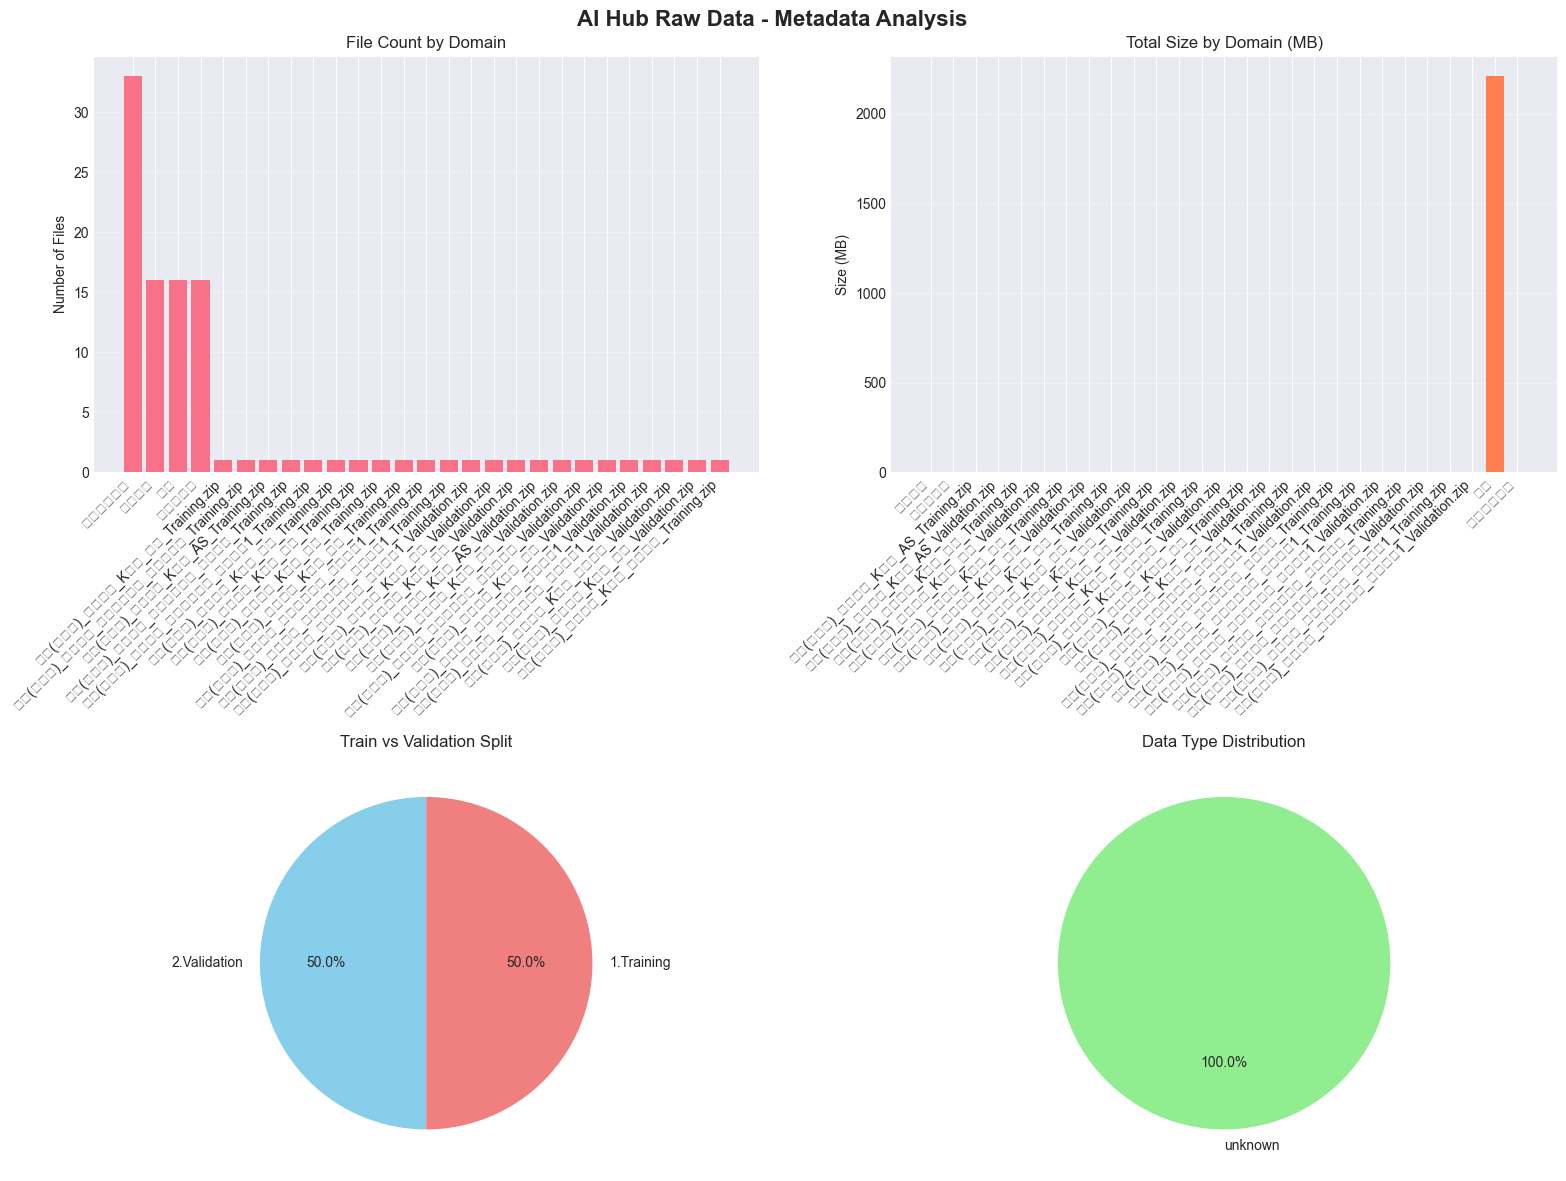

✓ Visualization saved to: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/metadata_analysis/metadata_overview.png


In [8]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("AI Hub Raw Data - Metadata Analysis", fontsize=16, fontweight="bold")

# 1. File count by domain
if "domain" in metadata_df.columns:
    domain_counts = metadata_df["domain"].value_counts()
    axes[0, 0].bar(range(len(domain_counts)), domain_counts.values)
    axes[0, 0].set_xticks(range(len(domain_counts)))
    axes[0, 0].set_xticklabels(domain_counts.index, rotation=45, ha="right")
    axes[0, 0].set_title("File Count by Domain")
    axes[0, 0].set_ylabel("Number of Files")
    axes[0, 0].grid(axis="y", alpha=0.3)

# 2. File size distribution by domain
if "domain" in metadata_df.columns:
    domain_sizes = metadata_df.groupby("domain")["file_size_mb"].sum()
    axes[0, 1].bar(range(len(domain_sizes)), domain_sizes.values, color="coral")
    axes[0, 1].set_xticks(range(len(domain_sizes)))
    axes[0, 1].set_xticklabels(domain_sizes.index, rotation=45, ha="right")
    axes[0, 1].set_title("Total Size by Domain (MB)")
    axes[0, 1].set_ylabel("Size (MB)")
    axes[0, 1].grid(axis="y", alpha=0.3)

# 3. Train vs Validation split
if "split" in metadata_df.columns:
    split_counts = metadata_df["split"].value_counts()
    axes[1, 0].pie(
        split_counts.values,
        labels=split_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=["skyblue", "lightcoral"],
    )
    axes[1, 0].set_title("Train vs Validation Split")

# 4. Data type distribution (라벨링 vs 원천)
if "data_type" in metadata_df.columns:
    datatype_counts = metadata_df["data_type"].value_counts()
    axes[1, 1].pie(
        datatype_counts.values,
        labels=datatype_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=["lightgreen", "lightyellow", "lightgray"],
    )
    axes[1, 1].set_title("Data Type Distribution")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "metadata_overview.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ Visualization saved to: {OUTPUT_DIR / 'metadata_overview.png'}")

## 7. File Size Analysis

/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/3693825396.py:20: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/3693825396.py:20: UserWarning: Glyph 50997 (\N{HANGUL SYLLABLE YUNG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/3693825396.py:20: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/3693825396.py:20: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/3693825396.py:20: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/lg/zz8kzx7j04q6lvkcyzwjznwh0000gn/T/ipykernel_20356/3693825396.py:20: U

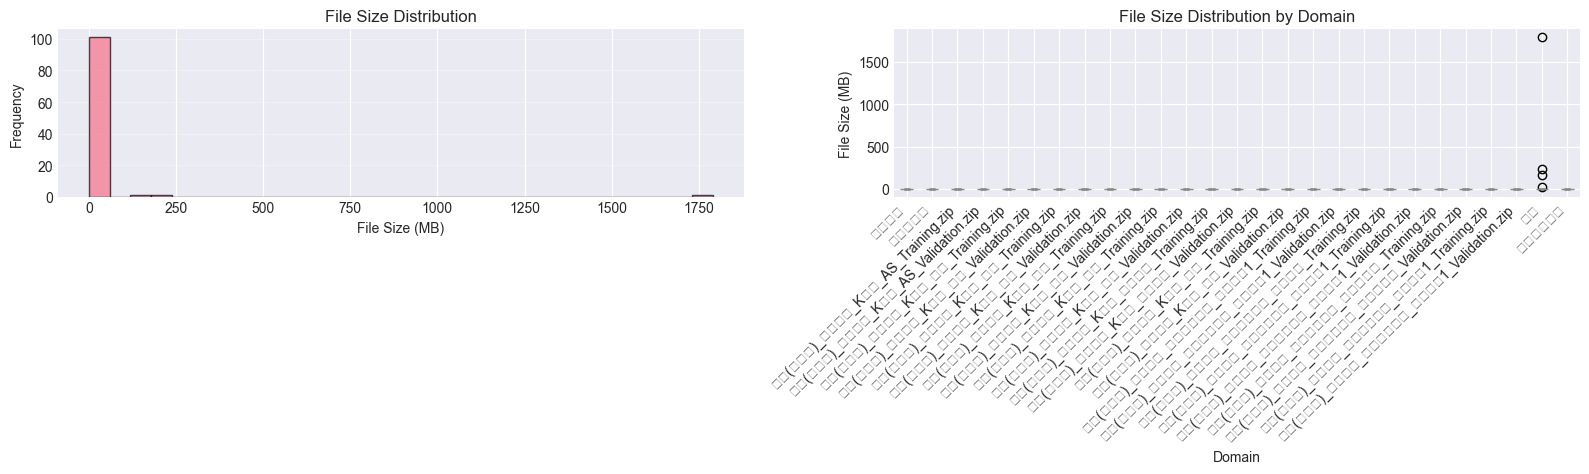

✓ Visualization saved to: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/metadata_analysis/file_size_analysis.png


In [9]:
# File size distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(metadata_df["file_size_mb"], bins=30, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("File Size (MB)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("File Size Distribution")
axes[0].grid(axis="y", alpha=0.3)

# Box plot by domain
if "domain" in metadata_df.columns:
    metadata_df.boxplot(column="file_size_mb", by="domain", ax=axes[1])
    axes[1].set_xlabel("Domain")
    axes[1].set_ylabel("File Size (MB)")
    axes[1].set_title("File Size Distribution by Domain")
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.suptitle("")  # Remove default title
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "file_size_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ Visualization saved to: {OUTPUT_DIR / 'file_size_analysis.png'}")

## 8. Cross-tabulation Analysis

/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50997 (\N{HANGUL SYLLABLE YUNG}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45796 (\

CROSS-TABULATION: Split x Domain
domain        금융보험  다산콜센터  민원(콜센터)_질의응답_K쇼핑_AS_Training.zip  \
split                                                         
1.Training       8      8                                 1   
2.Validation     8      8                                 0   

domain        민원(콜센터)_질의응답_K쇼핑_AS_Validation.zip  \
split                                              
1.Training                                     0   
2.Validation                                   1   

domain        민원(콜센터)_질의응답_K쇼핑_결제_Training.zip  \
split                                            
1.Training                                   1   
2.Validation                                 0   

domain        민원(콜센터)_질의응답_K쇼핑_결제_Validation.zip  \
split                                              
1.Training                                     0   
2.Validation                                   1   

domain        민원(콜센터)_질의응답_K쇼핑_교환_Training.zip  \
split                                        

/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50997 (\N{HANGUL SYLLABLE YUNG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sdh

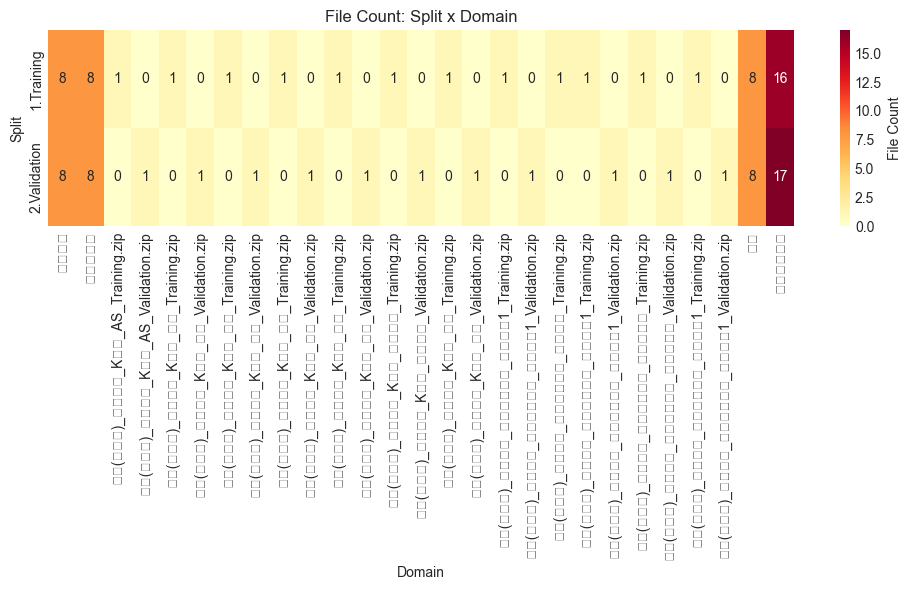

✓ Heatmap saved to: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/metadata_analysis/crosstab_split_domain.png


In [10]:
# Split x Domain crosstab
if "split" in metadata_df.columns and "domain" in metadata_df.columns:
    print("=" * 60)
    print("CROSS-TABULATION: Split x Domain")
    print("=" * 60)
    crosstab = pd.crosstab(metadata_df["split"], metadata_df["domain"])
    print(crosstab)
    print()

    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        crosstab, annot=True, fmt="d", cmap="YlOrRd", cbar_kws={"label": "File Count"}
    )
    plt.title("File Count: Split x Domain")
    plt.xlabel("Domain")
    plt.ylabel("Split")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "crosstab_split_domain.png", dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✓ Heatmap saved to: {OUTPUT_DIR / 'crosstab_split_domain.png'}")

/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50997 (\N{HANGUL SYLLABLE YUNG}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45796 (\

CROSS-TABULATION: Data Type x Domain
domain     금융보험  다산콜센터  민원(콜센터)_질의응답_K쇼핑_AS_Training.zip  \
data_type                                                  
unknown      16     16                                 1   

domain     민원(콜센터)_질의응답_K쇼핑_AS_Validation.zip  \
data_type                                       
unknown                                     1   

domain     민원(콜센터)_질의응답_K쇼핑_결제_Training.zip  \
data_type                                     
unknown                                   1   

domain     민원(콜센터)_질의응답_K쇼핑_결제_Validation.zip  \
data_type                                       
unknown                                     1   

domain     민원(콜센터)_질의응답_K쇼핑_교환_Training.zip  \
data_type                                     
unknown                                   1   

domain     민원(콜센터)_질의응답_K쇼핑_교환_Validation.zip  \
data_type                                       
unknown                                     1   

domain     민원(콜센터)_질의응답_K쇼핑_반품_Training.zip  \
data_ty

/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50997 (\N{HANGUL SYLLABLE YUNG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sdh/Dev/02_production_projects/humetro-ai-assistant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sdh

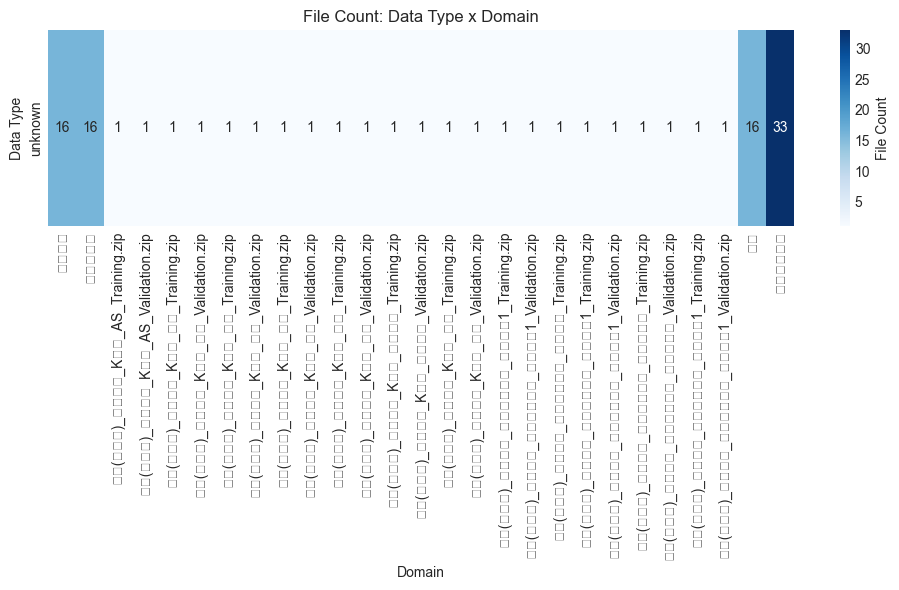

✓ Heatmap saved to: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/metadata_analysis/crosstab_datatype_domain.png


In [11]:
# Data Type x Domain crosstab
if "data_type" in metadata_df.columns and "domain" in metadata_df.columns:
    print("=" * 60)
    print("CROSS-TABULATION: Data Type x Domain")
    print("=" * 60)
    crosstab2 = pd.crosstab(metadata_df["data_type"], metadata_df["domain"])
    print(crosstab2)
    print()

    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        crosstab2, annot=True, fmt="d", cmap="Blues", cbar_kws={"label": "File Count"}
    )
    plt.title("File Count: Data Type x Domain")
    plt.xlabel("Domain")
    plt.ylabel("Data Type")
    plt.tight_layout()
    plt.savefig(
        OUTPUT_DIR / "crosstab_datatype_domain.png", dpi=300, bbox_inches="tight"
    )
    plt.show()
    print(f"✓ Heatmap saved to: {OUTPUT_DIR / 'crosstab_datatype_domain.png'}")

## 9. Sample Zip File Inspection

In [12]:
def inspect_zip_file(zip_path: Path, max_files: int = 10) -> Dict[str, Any]:
    """
    Inspect contents of a zip file without extracting.

    Args:
        zip_path: Path to zip file
        max_files: Maximum number of files to list

    Returns:
        Dictionary with zip file metadata
    """
    info = {
        "zip_file": zip_path.name,
        "file_count": 0,
        "total_size_mb": 0,
        "file_types": Counter(),
        "sample_files": [],
    }

    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            file_list = zf.namelist()
            info["file_count"] = len(file_list)

            # Calculate total size
            total_size = sum([zf.getinfo(name).file_size for name in file_list])
            info["total_size_mb"] = total_size / (1024 * 1024)

            # Count file types
            for name in file_list:
                ext = Path(name).suffix
                info["file_types"][ext] += 1

            # Sample files
            info["sample_files"] = file_list[:max_files]

    except Exception as e:
        info["error"] = str(e)

    return info


# Inspect a sample zip file from each domain
print("=" * 60)
print("SAMPLE ZIP FILE INSPECTION")
print("=" * 60)

zip_files = metadata_df[metadata_df["extension"] == ".zip"]
if len(zip_files) > 0:
    # Sample one file from each domain
    sample_files = zip_files.groupby("domain").first()

    for domain, row in sample_files.iterrows():
        print(f"\n{'=' * 60}")
        print(f"Domain: {domain}")
        print(f"File: {row['filename']}")
        print(f"{'=' * 60}")

        zip_info = inspect_zip_file(Path(row["file_path"]))

        print(f"Files in archive: {zip_info['file_count']:,}")
        print(f"Total size: {zip_info['total_size_mb']:.2f} MB")
        print(f"\nFile types:")
        for ext, count in zip_info["file_types"].most_common():
            print(f"  {ext or '(no extension)'}: {count:,}")

        print(f"\nSample files (first 5):")
        for i, fname in enumerate(zip_info["sample_files"][:5], 1):
            print(f"  {i}. {fname}")

SAMPLE ZIP FILE INSPECTION

Domain: 금융보험
File: 민원(콜센터)_질의응답_금융보험_잔고_및_거래내역_Validation.zip
Files in archive: 0
Total size: 0.00 MB

File types:

Sample files (first 5):

Domain: 다산콜센터
File: 민원(콜센터)_질의응답_다산콜센터_일반행정_문의_Validation.zip
Files in archive: 0
Total size: 0.00 MB

File types:

Sample files (first 5):

Domain: 민원(콜센터)_질의응답_K쇼핑_AS_Training.zip
File: 민원(콜센터)_질의응답_K쇼핑_AS_Training.zip
Files in archive: 0
Total size: 0.00 MB

File types:

Sample files (first 5):

Domain: 민원(콜센터)_질의응답_K쇼핑_AS_Validation.zip
File: 민원(콜센터)_질의응답_K쇼핑_AS_Validation.zip
Files in archive: 0
Total size: 0.00 MB

File types:

Sample files (first 5):

Domain: 민원(콜센터)_질의응답_K쇼핑_결제_Training.zip
File: 민원(콜센터)_질의응답_K쇼핑_결제_Training.zip
Files in archive: 0
Total size: 0.00 MB

File types:

Sample files (first 5):

Domain: 민원(콜센터)_질의응답_K쇼핑_결제_Validation.zip
File: 민원(콜센터)_질의응답_K쇼핑_결제_Validation.zip
Files in archive: 0
Total size: 0.00 MB

File types:

Sample files (first 5):

Domain: 민원(콜센터)_질의응답_K쇼핑_교환_Training.zip
File:

## 10. Summary Statistics Export

In [13]:
# Generate summary report
summary_stats = {
    "total_files": len(metadata_df),
    "total_size_mb": metadata_df["file_size_mb"].sum(),
    "avg_file_size_mb": metadata_df["file_size_mb"].mean(),
    "median_file_size_mb": metadata_df["file_size_mb"].median(),
    "unique_domains": metadata_df["domain"].nunique()
    if "domain" in metadata_df.columns
    else 0,
    "unique_splits": metadata_df["split"].nunique()
    if "split" in metadata_df.columns
    else 0,
}

# Save to JSON
with open(OUTPUT_DIR / "summary_statistics.json", "w", encoding="utf-8") as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)

print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

print(f"\n✓ Summary saved to: {OUTPUT_DIR / 'summary_statistics.json'}")

SUMMARY STATISTICS
total_files: 104
total_size_mb: 2209.55
avg_file_size_mb: 21.25
median_file_size_mb: 0.00
unique_domains: 27
unique_splits: 2

✓ Summary saved to: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/metadata_analysis/summary_statistics.json


In [14]:
# Save full metadata to CSV
output_csv = OUTPUT_DIR / "ai_hub_metadata_full.csv"
metadata_df.to_csv(output_csv, index=False, encoding="utf-8-sig")
print(f"✓ Full metadata saved to: {output_csv}")

# Save domain summary
if "domain" in metadata_df.columns:
    domain_summary = (
        metadata_df.groupby("domain")
        .agg({"filename": "count", "file_size_mb": ["sum", "mean", "min", "max"]})
        .round(2)
    )
    domain_summary.columns = [
        "File Count",
        "Total Size (MB)",
        "Avg Size (MB)",
        "Min Size (MB)",
        "Max Size (MB)",
    ]
    domain_summary.to_csv(OUTPUT_DIR / "domain_summary.csv", encoding="utf-8-sig")
    print(f"✓ Domain summary saved to: {OUTPUT_DIR / 'domain_summary.csv'}")

✓ Full metadata saved to: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/metadata_analysis/ai_hub_metadata_full.csv
✓ Domain summary saved to: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/metadata_analysis/domain_summary.csv


## 11. Data Quality Checks

In [15]:
print("=" * 60)
print("DATA QUALITY CHECKS")
print("=" * 60)

# Check for missing values
print("\nMissing Values:")
missing = metadata_df.isnull().sum()
missing_pct = (missing / len(metadata_df) * 100).round(2)
missing_df = pd.DataFrame({"Count": missing, "Percentage": missing_pct})
print(missing_df[missing_df["Count"] > 0])

# Check for duplicate files
print(f"\nDuplicate Filenames: {metadata_df['filename'].duplicated().sum()}")

# Check for very small or very large files
print(f"\nFiles < 1 MB: {(metadata_df['file_size_mb'] < 1).sum()}")
print(f"Files > 100 MB: {(metadata_df['file_size_mb'] > 100).sum()}")

# List largest files
print("\nTop 5 Largest Files:")
largest_files = metadata_df.nlargest(5, "file_size_mb")[
    ["filename", "file_size_mb", "domain"]
]
print(largest_files.to_string(index=False))

# List smallest files
print("\nTop 5 Smallest Files:")
smallest_files = metadata_df.nsmallest(5, "file_size_mb")[
    ["filename", "file_size_mb", "domain"]
]
print(smallest_files.to_string(index=False))

DATA QUALITY CHECKS

Missing Values:
Empty DataFrame
Columns: [Count, Percentage]
Index: []

Duplicate Filenames: 24

Files < 1 MB: 100
Files > 100 MB: 3

Top 5 Largest Files:
                                  filename  file_size_mb domain
                                    주문.zip   1789.135744     쇼핑
                                    주문.zip    237.649980     쇼핑
                                    AS.zip    164.101570     쇼핑
                                    AS.zip     18.664082     쇼핑
민원(콜센터)_질의응답_금융보험_잔고_및_거래내역_Validation.zip      0.000000   금융보험

Top 5 Smallest Files:
                                   filename  file_size_mb domain
 민원(콜센터)_질의응답_금융보험_잔고_및_거래내역_Validation.zip           0.0   금융보험
민원(콜센터)_질의응답_금융보험_사고_및_보상_문의_Validation.zip           0.0   금융보험
 민원(콜센터)_질의응답_금융보험_이체출금대출서비스_Validation.zip           0.0   금융보험
민원(콜센터)_질의응답_금융보험_상품_가입_및_해지_Validation.zip           0.0   금융보험
  민원(콜센터)_질의응답_다산콜센터_일반행정_문의_Validation.zip           0.0  다산콜센터


## 12. Conclusion & Next Steps

### Key Findings:
- Review the visualizations and statistics above
- Identified data distribution across domains and splits
- Analyzed file sizes and data types

### Next Steps:
1. **Extract and analyze content**: Unzip files and analyze actual data contents
2. **JSON structure analysis**: Parse JSON files within archives
3. **Text analysis**: Perform NLP analysis on conversation data
4. **Quality assessment**: Check data quality, completeness, and consistency
5. **Model training preparation**: Prepare data for training pipelines

In [16]:
print("=" * 60)
print("EDA COMPLETE")
print("=" * 60)
print(f"\nAll results saved to: {OUTPUT_DIR}")
print("\nGenerated files:")
for file in sorted(OUTPUT_DIR.glob("*")):
    print(f"  - {file.name}")

EDA COMPLETE

All results saved to: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/metadata_analysis

Generated files:
  - ai_hub_metadata_full.csv
  - crosstab_datatype_domain.png
  - crosstab_split_domain.png
  - domain_summary.csv
  - file_size_analysis.png
  - metadata_overview.png
  - summary_statistics.json
